In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
import statsmodels.formula.api as smf

from sklearn.pipeline import Pipeline
from sklearn import ensemble, neighbors
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn import svm
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from scipy import stats
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn import feature_selection
from sklearn.feature_selection import SelectKBest, f_classif

import warnings
warnings.filterwarnings('ignore')
sns.set_style('darkgrid')
plt.rcParams['figure.figsize'] = (20.0, 20.0)
plt.rcParams.update({'font.size': 25})
%matplotlib inline

# Background of Dataset

This is a synthetic financial dataset created for fraud detection generated by PaySim. PaySim simulates mobile money transactions based on a sample of real transactions extracted from one month of financial logs from a mobile money service implemented in an African country. The original logs were provided by a multinational company, who is the provider of the mobile financial service which is currently running in more than 14 countries all around the world.

The synthetic dataset is first aggregated using data from private datasets to generate a synthetic dataset that resmbles the normal opeartion of transactions and later injects malicious behavior to evaluate the performance of fraud detection methods.

Fraud in this context is defined as fraudulent mobile money transactions where an agent attempts to gain access to a customer's account and empty the funds by transferring to another account and cashing out of the system.

This synthetic dataset is scaled down 1/4 of the original dataset and it is created just for Kaggle. The link can be found here: https://www.kaggle.com/ntnu-testimon/paysim1


# Goal

With the data provided, I will create models that will accurately detect fraud. From those models, I will use methods to determine which model performs the strongest depending on computation time and accuracy.

## Headers
This is a sample of 1 row with headers explanation:

1,PAYMENT,1060.31,C429214117,1089.0,28.69,M1591654462,0.0,0.0,0,0

step - maps a unit of time in the real world. In this case 1 step is 1 hour of time. Total steps 744 (30 days simulation).

type - CASH-IN, CASH-OUT, DEBIT, PAYMENT and TRANSFER.

amount - amount of the transaction in local currency.

nameOrig - customer who started the transaction

oldbalanceOrg - initial balance before the transaction

newbalanceOrig - new balance after the transaction

nameDest - customer who is the recipient of the transaction

oldbalanceDest - initial balance recipient before the transaction. Note that there is not information for customers that start with M (Merchants).

newbalanceDest - new balance recipient after the transaction. Note that there is not information for customers that start with M (Merchants).

isFraud - This is the transactions made by the fraudulent agents inside the simulation. In this specific dataset the fraudulent behavior of the agents aims to profit by taking control or customers accounts and try to empty the funds by transferring to another account and then cashing out of the system.

isFlaggedFraud - The business model aims to control massive transfers from one account to another and flags illegal attempts. An illegal attempt in this dataset is an attempt to transfer more than 200,000 in a single transaction.

In [5]:
paysim_data = pd.read_csv('thinkful/paysim.csv')

# Exploratory Data Analysis (EDA)

In [7]:
paysim_data.head()

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0,0
1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0,0
2,1,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1,0
3,1,CASH_OUT,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,1,0
4,1,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0,0


In [8]:
# Acknowledging the shape and size of our data and what they are
paysim_data.shape

(6362620, 11)

In [9]:
paysim_data.dtypes

step                int64
type               object
amount            float64
nameOrig           object
oldbalanceOrg     float64
newbalanceOrig    float64
nameDest           object
oldbalanceDest    float64
newbalanceDest    float64
isFraud             int64
isFlaggedFraud      int64
dtype: object

- Because most of our datatypes are numbers, we will have an easier time of manipulating them later.
- "Type" will likely be converted to dummies to continue with the ability to manipulate numbers easier with other numbers.
- We will likely avoid "nameOrg" and "nameDest" due to the sheer amount of unique values within them, as they would not help our data much

In [10]:
# Checking data for any null values that might affect our data
paysim_data.isnull().values.any()

False

In [11]:
# Summarize our data
paysim_data.describe()

,step,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
count,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06
mean,2.433972e+02,1.798619e+05,8.338831e+05,8.551137e+05,1.100702e+06,1.224996e+06,1.290820e-03,2.514687e-06
std,1.423320e+02,6.038582e+05,2.888243e+06,2.924049e+06,3.399180e+06,3.674129e+06,3.590480e-02,1.585775e-03
min,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,1.560000e+02,1.338957e+04,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
50%,2.390000e+02,7.487194e+04,1.420800e+04,0.000000e+00,1.327057e+05,2.146614e+05,0.000000e+00,0.000000e+00
75%,3.350000e+02,2.087215e+05,1.073152e+05,1.442584e+05,9.430367e+05,1.111909e+06,0.000000e+00,0.000000e+00
max,7.430000e+02,9.244552e+07,5.958504e+07,4.958504e+07,3.560159e+08,3.561793e+08,1.000000e+00,1.000000e+00


From the values in our data, there don't seem to be any outliers in accordance to our max, standard deviations, and means other than "amount" which shouldn't affect our findings. 

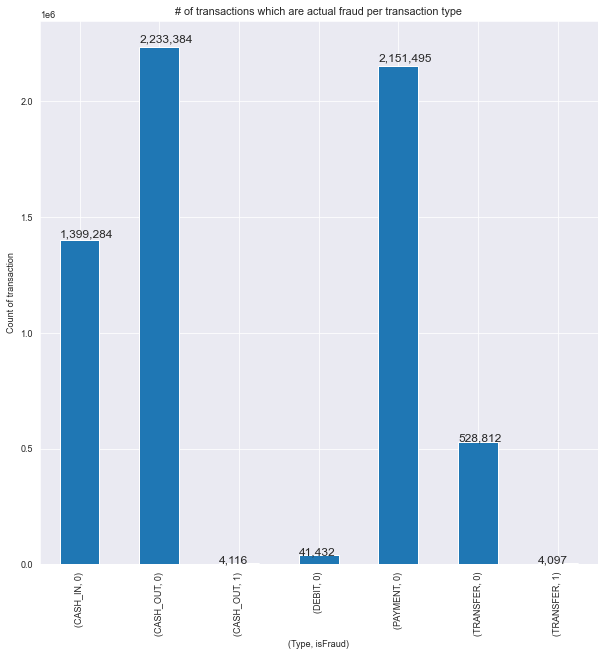

In [18]:
ax = paysim_data.groupby(['type', 'isFraud']).size().plot(kind='bar')
ax.set_title("# of transactions which are actual fraud per transaction type")
ax.set_xlabel("(Type, isFraud)")
ax.set_ylabel("Count of transaction")
plt.rcParams['figure.figsize'] = (10.0, 10.0)
plt.rcParams.update({'font.size': 12})
for p in ax.patches:
    ax.annotate(str(format(int(p.get_height()), ',d')), (p.get_x(), p.get_height()*1.01));


The only types of transactions that ended up as fraud were when things were cashed out or transferred, indicated the the "1" on this bar graph.

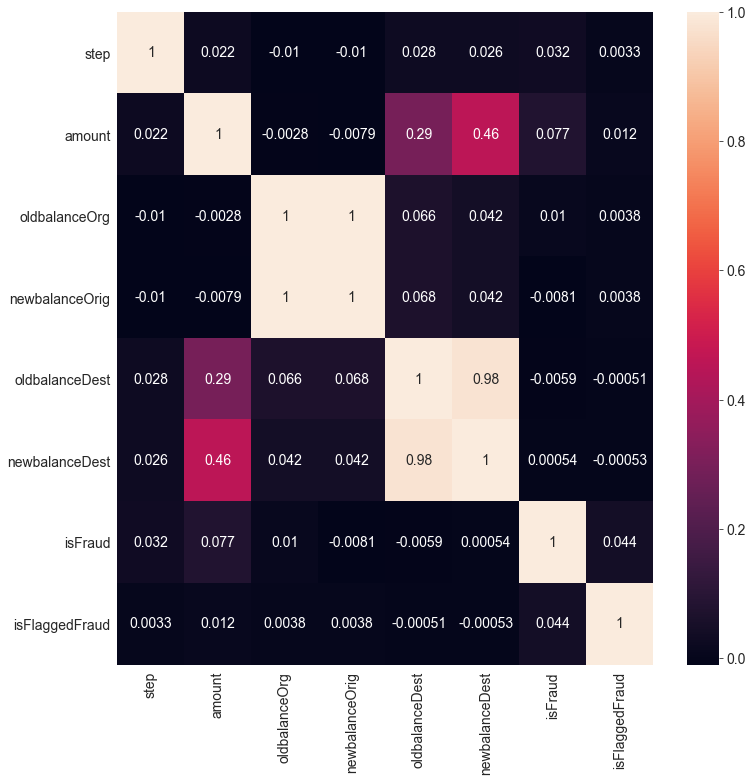

In [19]:
# Heatmap to see if there is any multicollinearity.
fraud = paysim_data.groupby('isFraud')
plt.rcParams['figure.figsize'] = (12.0, 12.0)
plt.rcParams.update({'font.size': 14})
sns.heatmap(paysim_data.corr(), annot=True);

Our data doesn't have much extreme positive or negative multicollinearity besides old and new balance and origin and destination, which will be dealt with.

# Data Adjustments

In [21]:
# Show what unique variables there are for type
list(paysim_data['type'].unique())

['PAYMENT', 'TRANSFER', 'CASH_OUT', 'DEBIT', 'CASH_IN']

In [22]:
# Convert these terms into continuous variables
type_dummies = pd.get_dummies(paysim_data['type'])

# Concatenate the dummies with original dataset
paysim_data = pd.concat([paysim_data,type_dummies],axis=1)

In [23]:
# Create droplist for the data that we will not be using for the models
droplist = ['nameOrig', 'nameDest', 'type']

# Create new subset of data to keep things clean
new_paysim = paysim_data.drop(droplist,1)

In [24]:
new_paysim.head()

,step,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud,CASH_IN,CASH_OUT,DEBIT,PAYMENT,TRANSFER
0,1,9839.64,170136.0,160296.36,0.0,0.0,0,0,0,0,0,1,0
1,1,1864.28,21249.0,19384.72,0.0,0.0,0,0,0,0,0,1,0
2,1,181.00,181.0,0.00,0.0,0.0,1,0,0,0,0,0,1
3,1,181.00,181.0,0.00,21182.0,0.0,1,0,0,1,0,0,0
4,1,11668.14,41554.0,29885.86,0.0,0.0,0,0,0,0,0,1,0


In [25]:
# Check if we have an even distribution of fraud
new_paysim['isFraud'].value_counts()

0    6354407
1       8213
Name: isFraud, dtype: int64

- 0.129% of our data is fraudulent
- In order to have a better distribution of fraud in the data, we will need to resample the data so the distribution is more even and workable.
- We could also choose to upsample, but the data would be even larger than it is now, so we will choose to downsample instead

In [27]:
from sklearn.utils import resample
# Resampling to 100,000 since the dataset is extremely large
# This way we have less non-fraudulent samples
paysim_majority = new_paysim[new_paysim.isFraud==0]
paysim_minority = new_paysim[new_paysim.isFraud==1]

# Downsample the majority class ()
paysim_majority_downsampled = resample(paysim_majority, 
                                 replace=True,     # sample with replacement
                                 n_samples=100000)  

# Upsample minority class
paysim_minority_upsampled = resample(paysim_minority, 
                                 replace=True,     # sample with replacement
                                 n_samples=100000) 

# Combine downsampled majority class with minority class
paysim_resampled = pd.concat([paysim_majority_downsampled, paysim_minority_upsampled])
 
# Display new class counts
paysim_resampled.isFraud.value_counts()

1    100000
0    100000
Name: isFraud, dtype: int64

In [28]:
# Creating a training and test set
# Set up variables
X = paysim_resampled.drop('isFraud', 1)
y = paysim_resampled.isFraud
# Create training and testing set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

# Model 1: Naive Bayes

In [29]:
# Our data continuous, so we're importing the Gaussian classifier.
from sklearn.naive_bayes import GaussianNB

# Instantiate our model and store it in a new variable.
gnb = GaussianNB()
kbest = SelectKBest(f_classif)

# Instantiate pipeline
gnb_pipeline = Pipeline([('kbest', kbest), ('gnb', GaussianNB())])

gnb_params = {'kbest__k': [1,2,3,4,5,6,7,8,9,10,11,12]}

# Set up parameters
gnb_grid = GridSearchCV(gnb_pipeline, gnb_params, cv=5, verbose=1, n_jobs=-1)

# Fit the grid and obtain results
gnb_grid.fit(X_train, y_train)

# Classify, storing the result in a new variable.
y_pred_train = gnb_grid.predict(X_test)

# Return best parameters and best score
print('Best parameters:')
print(gnb_grid.best_params_)
print('Best Score:')
print(gnb_grid.best_score_)

Fitting 5 folds for each of 12 candidates, totalling 60 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    5.5s


Best parameters:
{'kbest__k': 3}
Best Score:
0.7788285714285713


[Parallel(n_jobs=-1)]: Done  60 out of  60 | elapsed:    6.6s finished


In [30]:
# Set up the best parameters
best_param = {'kbest__k': [3]}

# Set up a new grid
best_gnb_grid = GridSearchCV(gnb_pipeline, best_param, cv=5, verbose=1, n_jobs=-1)

# Cross Validate the model.
cross_val_score(best_gnb_grid, X_train, y_train, cv=10)

Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.3s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.3s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.3s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.3s finished


array([0.78285714, 0.77835714, 0.78121429, 0.77678571, 0.77735714,
       0.77864286, 0.779     , 0.778     , 0.77742857, 0.77864286])

In [31]:
# Create a confusion matrix
confusion_matrix(y_test, y_pred_train)

array([[16608, 13196],
       [    0, 30196]], dtype=int64)

In [34]:
# Create a classification report
print(classification_report(y_test, y_pred_train))

              precision    recall  f1-score   support

           0       1.00      0.56      0.72     29804
           1       0.70      1.00      0.82     30196

    accuracy                           0.78     60000
   macro avg       0.85      0.78      0.77     60000
weighted avg       0.85      0.78      0.77     60000



In [36]:
from sklearn.metrics import auc, precision_recall_curve

# Check the area under the precision recall curve
precision, recall, thresholds = precision_recall_curve(y_test, y_pred_train)

auc(precision, recall)

0.1520556784660767

# Analysis 1: Naive Bayes

Using Gaussian Naive Bayes (GNB) allowed for continuous variables while using Bernoulli required more binary features. The accuracy was only about 75% for this model which is reasonable because there was a binary classifier included in the prediction "isFlaggedFraud", which could have held back the ability to predict of GNB. Error type II was the main issue, where it failed to recognize fraud, marking negative where it should have been positive. 

The runtime of the model was extremely fast, but likely due to the shallowness of the feature selection. Quick but not accurate.

# Model 2: KNN

In [52]:
from sklearn.preprocessing import StandardScaler

ss = StandardScaler()

# Set up the variables.
# Set up variables
X = paysim_resampled.drop('isFraud', 1)
y = paysim_resampled['isFraud'].values.reshape(-1, 1)

# Standarize the data first 
ss.fit(X,y)

# Now that the data is ready
transform_x = ss.transform(X)

In [54]:
# Create training and testing set for knn
knn_Xtrain, knn_Xtest, knn_ytrain, knn_ytest = train_test_split(transform_x, y, test_size=0.3)

In [55]:
from sklearn.neighbors import KNeighborsClassifier

# Initialize the model and SelectKBest features
knn = KNeighborsClassifier()

# Let all of the features be an option
kbest = SelectKBest(f_classif)

# Instantiate pipeline
knn_pipeline = Pipeline([('kbest', kbest), ('knn', KNeighborsClassifier())])

knn_params = {'kbest__k': [1,2,3,4,5,6,7,8,9,10,11,12],
                                     'knn__n_neighbors':[2,4,5,7,9,10,20,40,50,75]}

# Set up parameters
knn_grid = GridSearchCV(knn_pipeline, knn_params, cv=5, verbose=1, n_jobs=-1)

# Fit the grid and obtain results
knn_grid.fit(knn_Xtrain, knn_ytrain)

# Return best parameters and best score
print('Best parameters:')
print(knn_grid.best_params_)
print('Best Score:')
print(knn_grid.best_score_)

Fitting 5 folds for each of 120 candidates, totalling 600 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  9.1min
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed: 33.0min
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed: 63.0min
[Parallel(n_jobs=-1)]: Done 600 out of 600 | elapsed: 107.1min finished


Best parameters:
{'kbest__k': 8, 'knn__n_neighbors': 2}
Best Score:
0.9934571428571429


In [56]:
# Set up the best parameters
best_param = {'kbest__k': [8],'knn__n_neighbors': [2]}

# Set up a new grid
best_knn_grid = GridSearchCV(knn_pipeline, best_param, cv=5, verbose=1, n_jobs=-1)

# Lets cross validate.
cross_val_score(best_knn_grid, knn_Xtrain, knn_ytrain, cv=5)

Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   32.4s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   30.7s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   31.0s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   31.0s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   35.7s finished


array([0.99314286, 0.99378571, 0.99357143, 0.99360714, 0.99317857])

In [57]:
# Fit our model to the data.
best_knn_grid.fit(knn_Xtrain, knn_ytrain)

# Classify, storing the result in a new variable.
knn_pred = best_knn_grid.predict(knn_Xtest)

# Create a confusion matrix.
confusion_matrix(knn_ytest, knn_pred)

Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   58.4s finished


array([[29819,   333],
       [    4, 29844]], dtype=int64)

In [59]:
# Create a classification report.
print(classification_report(knn_ytest, knn_pred))

              precision    recall  f1-score   support

           0       1.00      0.99      0.99     30152
           1       0.99      1.00      0.99     29848

    accuracy                           0.99     60000
   macro avg       0.99      0.99      0.99     60000
weighted avg       0.99      0.99      0.99     60000



In [68]:
# Check the area under the precision recall curve. 
precision, recall, thresholds = precision_recall_curve(knn_ytest, knn_pred)

auc(precision, recall)

0.4969822134397673

# Analysis 2: KNN

The KNN model was accurate likely because the features were normalized so it could correctly calculate the euclidean distance. Most of the nearest neighbors were classified correctly. But because of the extremely high accuracy of 99%, the data seems to have been overfitted with this model given that we had a total of 200,000 rows.

The fact the model only took 2 neighbors to determine whether the transaction was fraudulent or not is concerning. And the model is able to explain only about half of the model according to the Area Under the Curve (AUC).

Although the model performed quickly, the accuracy is still not enough to be a good classifier.

# Model 3: Decision Tree

In [118]:
from sklearn.tree import DecisionTreeClassifier

# Initialize the model
dtc = DecisionTreeClassifier()

# Instantiate pipeline
dtc_pipeline = Pipeline([('kbest', kbest), ('dtc', DecisionTreeClassifier())])

dtc_params = {'kbest__k': [1,2,3,4,5,6,7,8,9,10,11,12],
                        'dtc__max_depth':[2,4,6,8]}

# Set up parameters
dtc_grid = GridSearchCV(dtc_pipeline, dtc_params, cv=5, verbose=1, n_jobs=-1)

# Fit the grid and obtain results
dtc_grid.fit(X_train, y_train)

# Return best parameters and best score
print('Best parameters:')
print(dtc_grid.best_params_)
print('Best Score:')
print(dtc_grid.best_score_)

Fitting 5 folds for each of 48 candidates, totalling 240 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    3.3s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:   20.5s
[Parallel(n_jobs=-1)]: Done 240 out of 240 | elapsed:   27.0s finished


Best parameters:
{'dtc__max_depth': 8, 'kbest__k': 12}
Best Score:
0.9894928571428571


In [120]:
# Set up the best parameters
best_param = {'kbest__k': [12],'dtc__max_depth': [8]}

# Set up a new grid
best_dtc_grid = GridSearchCV(dtc_pipeline, best_param, cv=5, verbose=1, n_jobs=-1)

# Cross Validate the decision tree model. 
cross_val_score(best_dtc_grid, X_train, y_train, cv=5)

Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    1.1s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    1.0s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.9s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.9s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    1.0s finished


array([0.98975   , 0.98942857, 0.98946429, 0.98925   , 0.98967857])

In [121]:
# Fit our model to the data.
best_dtc_grid.fit(X_train, y_train)

# Classify, storing the result in a new variable.
dtc_pred = best_dtc_grid.predict(X_test)

# Create a confusion matrix.
confusion_matrix(y_test, dtc_pred)

Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    1.3s finished


array([[29273,   531],
       [  124, 30072]], dtype=int64)

In [122]:
# Create a classification report.
print(classification_report(y_test, dtc_pred))

              precision    recall  f1-score   support

           0       1.00      0.98      0.99     29804
           1       0.98      1.00      0.99     30196

    accuracy                           0.99     60000
   macro avg       0.99      0.99      0.99     60000
weighted avg       0.99      0.99      0.99     60000



In [123]:
# Check the area under the precision recall curve. 
precision, recall, thresholds = precision_recall_curve(y_test, dtc_pred)

auc(precision, recall)

0.4870377945430464

# Analysis: Decision Tree

The accuracy of the decision tree ended up being extremely high as well. It was likely able to attain such high accuracy due to the use of maximum depth, but it then suffers again from overfitting, covering only 48% of our data as indicated by the AUC.

It's a strong performer regardless because of the speed at which is performed and highest accuracy by far, about on par with K-Nearest Neighbors.

# Model 4: Random Forest

In [70]:
#Instantiate random forest
rfc = ensemble.RandomForestClassifier()

#Instantiate pipeline
rfc_pipeline = Pipeline([('kbest',kbest),('rfc',ensemble.RandomForestClassifier())])

#Create the rfc parameters for GS-CV
param_grid = {'kbest__k': [1,2,3,4,5,6,7,8,9,10,11,12],
              'rfc__n_estimators': [10, 25, 50, 75, 100, 200, 500, 1000],
             'rfc__max_depth': [2, 4, 6]}

#Utilize GS-CV
rfc_grid = GridSearchCV(rfc_pipeline,param_grid,cv=5,verbose=1,n_jobs=-1)

rfc_grid.fit(X_train,y_train)

#Show best parametrs and best score
print('Best Parameter for data:', rfc_grid.best_params_)
print('\nBest Score for data:', rfc_grid.best_score_)

Fitting 5 folds for each of 288 candidates, totalling 1440 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:  6.9min
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed: 19.9min
[Parallel(n_jobs=-1)]: Done 792 tasks      | elapsed: 43.9min
[Parallel(n_jobs=-1)]: Done 1242 tasks      | elapsed: 86.7min
[Parallel(n_jobs=-1)]: Done 1440 out of 1440 | elapsed: 106.5min finished


Best Parameter for data: {'kbest__k': 9, 'rfc__max_depth': 6, 'rfc__n_estimators': 50}

Best Score for data: 0.9750214285714286


In [124]:
# Use best parameters
best_param = {'kbest__k': [9],'rfc__max_depth': [6], 'rfc__n_estimators':[50]}

#New grid
# Set up a new grid
best_rfc_grid = GridSearchCV(rfc_pipeline, best_param, cv=5, verbose=1, n_jobs=-1)

# Cross Validate the random forest model.  
cross_val_score(best_rfc_grid, X_train, y_train, cv=5)

Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    8.3s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    7.2s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    6.3s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    6.1s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    7.4s finished


array([0.97167857, 0.97628571, 0.97167857, 0.98464286, 0.97657143])

In [125]:
# Fit our model to the data.
best_rfc_grid.fit(X_train, y_train)

# Classify, storing the result in a new variable.
rfc_pred = best_rfc_grid.predict(X_test)

# Create a confusion matrix.
confusion_matrix(y_test, rfc_pred)

Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    7.7s finished


array([[28863,   941],
       [  765, 29431]], dtype=int64)

In [126]:
# Create a classification report.
print(classification_report(y_test, rfc_pred))

              precision    recall  f1-score   support

           0       0.97      0.97      0.97     29804
           1       0.97      0.97      0.97     30196

    accuracy                           0.97     60000
   macro avg       0.97      0.97      0.97     60000
weighted avg       0.97      0.97      0.97     60000



In [127]:
# Check the area under the precision recall curve. 
precision, recall, thresholds = precision_recall_curve(y_test, rfc_pred)

auc(precision, recall)

0.474949850705842

# Analysis 4: Random Forest

The model ended up having 75 trees as the best set of parameters, which is quite deep for the data set. This is also proven by the extremely high accuracy, which means the model may be adhering to the noise in the data set. The AUC ends up being around 48% as well, very similar to our last classifiers.

It still does make it a strong performer, but becaues of how many trees it goes through, it's no surprise it took around 2.5 hours for it to complete, making it fail in speed.

# Model 5: Logistic Regression

In [75]:
from sklearn.linear_model import LogisticRegression
lr = LogisticRegression()

# Use GS-CV to see which alpha level is best.

# Instantiate pipeline
lr_pipeline = Pipeline([('kbest', kbest), ('lr', LogisticRegression(penalty='l2'))])

# Create rfc parameters for GS-CV
param_grid = {'kbest__k': [1,2,3,4,5,6,7,8,9,10,11,12],
              'lr__C':[0.00001,0.0001,0.001,0.01,0.1,1,10,100,10000,100000,100000000]}


# Set up GS-CV
lr_grid = GridSearchCV(lr_pipeline, param_grid, cv=5, verbose=1, n_jobs=-1)

#Fit the logistic regression 
lr_grid.fit(X_train, y_train)

#return best parameters and best score
print('Best parameters:')
print(lr_grid.best_params_)
print('Best Score:')
print(lr_grid.best_score_)

Fitting 5 folds for each of 132 candidates, totalling 660 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    3.0s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:   19.6s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done 660 out of 660 | elapsed:  2.5min finished


Best parameters:
{'kbest__k': 8, 'lr__C': 1e-05}
Best Score:
0.9052642857142856


In [78]:
# Implement parameter 
best_lr = LogisticRegression(C=1e-05, penalty='l2')

# Cross Validate the lr model. 
cross_val_score(lr, X_train, y_train, cv=5)

array([0.90435714, 0.90432143, 0.90432143, 0.90196429, 0.90757143])

In [79]:
# Fit our model to the data.
best_lr.fit(X_train, y_train)

# Classify, storing the result in a new variable.
lr_pred = best_lr.predict(X_test)

# Create a confusion matrix.
confusion_matrix(y_test, lr_pred)

array([[27224,  2580],
       [ 3084, 27112]], dtype=int64)

In [80]:
# Create a classification report.
print(classification_report(y_test, lr_pred))

              precision    recall  f1-score   support

           0       0.90      0.91      0.91     29804
           1       0.91      0.90      0.91     30196

    accuracy                           0.91     60000
   macro avg       0.91      0.91      0.91     60000
weighted avg       0.91      0.91      0.91     60000



In [81]:
# Check the area under the precision recall curve. 
precision, recall, thresholds = precision_recall_curve(y_test, lr_pred)

auc(precision, recall)

0.4279209208541705

# Analysis 5: Logistic Regression

Ridge regularization was used on this dataset due to the large amount of rows within it. This way we can avoid increasing the size of the coefficient. In order to avoid overweighting the importance of features, ridge regularization is used.

So utilizing the best parameters, we see the regularization was slightly stronger. In terms of accuracy, it does slightly worse when compared to our previous models, but it performs much more quickly.

# Model 6: Gradient Boosting Model

In [82]:
# Initialize and fit the model.
clf = ensemble.GradientBoostingClassifier()

# Instantiate pipeline
clf_pipeline = Pipeline([('kbest', kbest), ('clf', ensemble.GradientBoostingClassifier())])

# Create rfc parameters for GS-CV
param_grid = {'kbest__k': [1,2,3,4,5,6,7,8,9,10,11,12],
              'clf__n_estimators': [100,200,500,800,1000],
             'clf__max_depth': [2,4,6]}


# Set up GS-CV
clf_grid = GridSearchCV(clf_pipeline, param_grid, cv=5, verbose=1, n_jobs=-1)

#Fit the logistic regression 
clf_grid.fit(X_train, y_train)


# Return best parameters and best score
print('Best parameters:')
print(clf_grid.best_params_)
print('Best Score:')
print(clf_grid.best_score_)

Fitting 5 folds for each of 180 candidates, totalling 900 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed: 27.0min
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed: 118.1min
[Parallel(n_jobs=-1)]: Done 792 tasks      | elapsed: 335.3min
[Parallel(n_jobs=-1)]: Done 900 out of 900 | elapsed: 1010.9min finished


Best parameters:
{'clf__max_depth': 6, 'clf__n_estimators': 1000, 'kbest__k': 12}
Best Score:
0.9983428571428572


In [134]:
# Set up the best parameters
best_clf_param = {'kbest__k': [12],'clf__n_estimators': [1000], 'clf__max_depth':[6]}

# Set up a new grid
best_clf_grid = GridSearchCV(clf_pipeline, best_clf_param, cv=5, verbose=1, n_jobs=-1)

# Cross Validate the gradient boosting model. 
cross_val_score(best_clf_grid, X_train, y_train, cv=5)

Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed: 10.6min finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed: 10.2min finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed: 10.1min finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed: 10.1min finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed: 10.1min finished


array([0.99846429, 0.99864286, 0.99785714, 0.99817857, 0.99860714])

In [135]:
# Fit our model to the data.
best_clf_grid.fit(X_train, y_train)

# Classify, storing the result in a new variable.
clf_pred = best_clf_grid.predict(X_test)

# Create a confusion matrix.
confusion_matrix(y_test, clf_pred)

Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed: 13.2min finished


array([[29719,    85],
       [    0, 30196]], dtype=int64)

In [136]:
# Create a classification report.
print(classification_report(y_test, clf_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     29804
           1       1.00      1.00      1.00     30196

    accuracy                           1.00     60000
   macro avg       1.00      1.00      1.00     60000
weighted avg       1.00      1.00      1.00     60000



In [137]:
# Check the area under the precision recall curve. 
precision, recall, thresholds = precision_recall_curve(y_test, clf_pred)

auc(precision, recall)

0.0014035203593011913

# Analysis 6: Gradient Boosting Model

This performed extremely well as well, as there were less false negatives as opposed to false positives. Since this model learns from iteration to iteration using the boosting method versus bagging, it performed extremely well. But the model suffered again from overfitting as did most of the other models.

Additionally, the model suffered from not having precision, only explaning less than 1% of the data. The 8+ hours run time for something this unprecise has to be due to overfitting the data.

# Utilizing Principal Component Analysis

The weakest model we have are the support vectors, Naive Bayes, and the logistic regression model. Instead of SKB, we will try to run PCA and see if the models will improve in performance.

In order to compare feature selection methods, we will run each of the models with PCA instead. Unlike SKB, PCA doesn't use any given features. Instead, it creates new features out of a combination of the initial features that are independent and have little to no multicollinearity. Most of the variance in each of the datasets was about 5 columns, so 5 or less PCA components would make the most sense. Here we are using 4 components.

In [86]:
# Prepare the data first for PCA
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

# Instantiate StandardScaler
ss = StandardScaler()

# Set up the variables.
# Set up variables
X = paysim_resampled.drop('isFraud', 1)
y = paysim_resampled['isFraud'].values.reshape(-1, 1)

# Standarize and fit the data first 
stand_x = ss.fit_transform(X)

In [87]:
# Use 4 components since it will explain most of the variance.
pca = PCA(n_components=4)

# Create a new training and testing set
X_train2, X_test2, y_train2, y_test2 = train_test_split(stand_x, y, test_size=0.3)

# Fit and transform training and testing dataset with PCA
X_train_pca = pca.fit_transform(X_train2)
X_test_pca = pca.fit_transform(X_test2)

# Model 7: PCA Naive Bayes

In [88]:
# Instantiate our model and store it in a new variable.
gnb = GaussianNB()

# Fit our model to the data.
gnb.fit(X_train_pca, y_train2)

# Classify, storing the result in a new variable.
y_pred_train2 = gnb.predict(X_test_pca)

# Display our results.
print(str(100*gnb.fit(X_train_pca, y_train2).score(X_test_pca, y_test2)) + '%')

83.63000000000001%


In [89]:
# Cross Validate the model.
cross_val_score(gnb, X_train_pca, y_train2, cv=10)

array([0.83042857, 0.82307143, 0.82314286, 0.83135714, 0.82535714,
       0.83314286, 0.82414286, 0.824     , 0.82807143, 0.8255    ])

In [90]:
# Create a confusion matrix.
confusion_matrix(y_test2, y_pred_train2)

array([[25360,  4641],
       [ 5181, 24818]], dtype=int64)

In [91]:
# Create a classification report.
print(classification_report(y_test2, y_pred_train2))

              precision    recall  f1-score   support

           0       0.83      0.85      0.84     30001
           1       0.84      0.83      0.83     29999

    accuracy                           0.84     60000
   macro avg       0.84      0.84      0.84     60000
weighted avg       0.84      0.84      0.84     60000



In [92]:
# Check the area under the precision recall curve. 
precision, recal, thresholds = precision_recall_curve(y_test2, y_pred_train2)

auc(precision, recall)

0.39571213777179126

# Analysis 7: PCA Naive Bayes

The PCA feature selection on this model negatively affected the model greatly, decreasing the precision in AUC by about 10%.

# Model 8: PCA KNN

In [93]:
# Set parameters for KNN
knn_params = [{'n_neighbors': [2,5,7,10,12,15,20]}]

# Search for the best paramters. 
knn_grid = GridSearchCV(knn, knn_params, cv=5, verbose=1, n_jobs=-1)

# Fit the grid and obtain results
knn_grid.fit(X_train_pca, y_train2)

# Return best parameters and best score
print('Best parameters:')
print(knn_grid.best_params_)
print('Best Score:')
print(knn_grid.best_score_)

Fitting 5 folds for each of 7 candidates, totalling 35 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  35 out of  35 | elapsed:   18.3s finished


Best parameters:
{'n_neighbors': 2}
Best Score:
0.9885785714285713


In [94]:
# Initialize the model
knn = KNeighborsClassifier(n_neighbors=2)

# Lets check for overfitting now.
cross_val_score(knn, X_train_pca, y_train2, cv=5)

array([0.98767857, 0.98960714, 0.98746429, 0.98942857, 0.98871429])

In [95]:
# Fit our model to the data.
knn.fit(X_train_pca, y_train2)

# Classify, storing the result in a new variable.
knn_pred2 = knn.predict(X_test_pca)

# Create a confusion matrix.
confusion_matrix(y_test2, knn_pred2)

array([[27997,  2004],
       [ 8698, 21301]], dtype=int64)

In [96]:
# Create a classification report.
print(classification_report(y_test2, knn_pred2))

              precision    recall  f1-score   support

           0       0.76      0.93      0.84     30001
           1       0.91      0.71      0.80     29999

    accuracy                           0.82     60000
   macro avg       0.84      0.82      0.82     60000
weighted avg       0.84      0.82      0.82     60000



In [97]:
# Check the area under the precision recall curve. 
precision, recall, thresholds = precision_recall_curve(y_test2, knn_pred2)

auc(precision, recall)

0.3845334355134301

# Analysis 8: KNN PCA

PCA increased the speed of our model drastically. The accuracy remains about the same, but the model itself ran much better.

# Model 9: PCA Decision Tree

In [98]:
# Initialize the model
dtc = DecisionTreeClassifier()

# Set parameters for dtc
dtc_params = [{'max_depth': [2, 4, 6, 8]}]

# Search for the best paramters. 
dtc_grid = GridSearchCV(dtc, dtc_params, cv=5, verbose=1, n_jobs=-1)

# Fit the grid and obtain results
dtc_grid.fit(X_train_pca, y_train2)

# Return best parameters and best score
print('Best parameters:')
print(dtc_grid.best_params_)
print('Best Score:')
print(dtc_grid.best_score_)

Fitting 5 folds for each of 4 candidates, totalling 20 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed:    1.8s finished


Best parameters:
{'max_depth': 8}
Best Score:
0.9326428571428572


In [99]:
# Implement the parameters.
dtc = DecisionTreeClassifier(max_features='auto', max_depth=8)

# Cross Validate the decision tree model. 
cross_val_score(dtc, X_train_pca, y_train2, cv=5)

array([0.9205    , 0.92453571, 0.91939286, 0.91714286, 0.92528571])

In [100]:
# Fit our model to the data.
dtc.fit(X_train_pca, y_train2)

# Classify, storing the result in a new variable.
dtc_pred2 = dtc.predict(X_test_pca)

# Create a confusion matrix.
confusion_matrix(y_test2, dtc_pred2)

array([[28416,  1585],
       [ 7155, 22844]], dtype=int64)

In [101]:
# Create a classification report.
print(classification_report(y_test2, dtc_pred2))

              precision    recall  f1-score   support

           0       0.80      0.95      0.87     30001
           1       0.94      0.76      0.84     29999

    accuracy                           0.85     60000
   macro avg       0.87      0.85      0.85     60000
weighted avg       0.87      0.85      0.85     60000



In [102]:
# Check the area under the precision recall curve. 
precision, recall, thresholds = precision_recall_curve(y_test2, dtc_pred2)

auc(precision, recall)

0.407946740205823

# Analysis 9: PCA Decision Tree

This model was only slightly worse in precision, but it ran much faster and did not overfit, which is a more believable scenario in these situations. Since it did perform quite a bit faster and did not suffer from overfitting, the precision lost is negligible, as this model can likely be used in multiple other settings.

# Model 10: PCA Random Forest

In [103]:
# Create rfc parameters for GS-CV
param_grid = {'n_estimators': [10, 25, 50, 75, 100, 200, 500, 1000],
             'max_depth': [2, 4, 6, 8]}

# Set up GS-CV
grid = GridSearchCV(rfc, param_grid, cv=5, verbose=1, n_jobs=-1)

grid.fit(X_train_pca, y_train2)

# Show the best parameter and best score for unfiltered
print('Best Parameter for data:', grid.best_params_)
print('\nBest Score for data:', grid.best_score_)

Fitting 5 folds for each of 32 candidates, totalling 160 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  3.0min
[Parallel(n_jobs=-1)]: Done 160 out of 160 | elapsed: 39.8min finished


Best Parameter for data: {'max_depth': 8, 'n_estimators': 10}

Best Score for data: 0.9328071428571428


In [138]:
# Implement the parameters
rfc = ensemble.RandomForestClassifier(n_estimators=10, max_features='auto',
                                     max_depth=8)

# Cross Validate the random forest model.  
cross_val_score(rfc, X_train_pca, y_train2, cv=5)

array([0.92796429, 0.92582143, 0.93421429, 0.93389286, 0.93196429])

In [139]:
# Fit our model to the data.
rfc.fit(X_train_pca, y_train2)

# Classify, storing the result in a new variable.
rfc_pred2 = rfc.predict(X_test_pca)

# Create a confusion matrix.
confusion_matrix(y_test2, rfc_pred2)

array([[28689,  1312],
       [ 6649, 23350]], dtype=int64)

In [140]:
# Create a classification report.
print(classification_report(y_test2, rfc_pred2))

              precision    recall  f1-score   support

           0       0.81      0.96      0.88     30001
           1       0.95      0.78      0.85     29999

    accuracy                           0.87     60000
   macro avg       0.88      0.87      0.87     60000
weighted avg       0.88      0.87      0.87     60000



In [141]:
# Check the area under the precision recall curve. 
precision, recall, thresholds = precision_recall_curve(y_test2, rfc_pred2)

auc(precision, recall)

0.4180050123648595

# Analysis 10: PCA Random Forest Classifier

The results are very similar to the SKB model results, but the AUC is slightly smaller. The model used the maximum depths and added more trees, but using PCA our model ended up not overfitting the rest of the data. The PCA also made our RFC a lot faster. That I believe makes this a top contender for this scenario.

# Model 11: PCA Logistic Regression

In [108]:
lr = LogisticRegression()

# Use GS-CV to see which alpha level is best.
parameters = {
             'C':[0.00001,0.0001,0.001,0.01,0.1,1,10,100,10000,100000,100000000]}

lr_grid = GridSearchCV(lr, parameters, cv=5, verbose=1)

#Fit the logistic regression 
lr_grid.fit(X_train_pca, y_train2)

#return best parameters and best score
print('Best parameters:')
print(lr_grid.best_params_)
print('Best Score:')
print(lr_grid.best_score_)

Fitting 5 folds for each of 11 candidates, totalling 55 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Best parameters:
{'C': 0.001}
Best Score:
0.8281071428571429


[Parallel(n_jobs=1)]: Done  55 out of  55 | elapsed:    4.6s finished


In [142]:
# Implement parameter 
lr = LogisticRegression(C=0.001, penalty='l2')

# Cross Validate the lr model. 
cross_val_score(lr, X_train_pca, y_train2, cv=5)

array([0.82785714, 0.82842857, 0.82953571, 0.82589286, 0.82882143])

In [143]:
# Fit our model to the data.
lr.fit(X_train_pca, y_train2)

# Classify, storing the result in a new variable.
lr_pred2 = lr.predict(X_test_pca)

# Create a confusion matrix.
confusion_matrix(y_test2, lr_pred2)

array([[25577,  4424],
       [ 5154, 24845]], dtype=int64)

In [144]:
# Create a classification report.
print(classification_report(y_test2, lr_pred2))

              precision    recall  f1-score   support

           0       0.83      0.85      0.84     30001
           1       0.85      0.83      0.84     29999

    accuracy                           0.84     60000
   macro avg       0.84      0.84      0.84     60000
weighted avg       0.84      0.84      0.84     60000



In [145]:
# Check the area under the precision recall curve. 
precision, recall, thresholds = precision_recall_curve(y_test2, lr_pred2)

auc(precision, recall)

0.38148896296319235

# Analysis 11: PCA Logistic Regression

This method ends up worse that its SKB counterpart in all but speed. It's less accurate and it was only faster than the SKB model by about 2 minutes, which is negligible by our standards.

# Model 12: PCA Gradient Boosting Model

In [129]:
# Initialize and fit the model.
clf = ensemble.GradientBoostingClassifier()

# Set up Gradient boosting parameters. 
gb_params = [{'n_estimators': [100,200,500,800,1000],
             'max_depth': [2,4,6,8],
             'learning_rate': [0.1, 0.3, 0.5]}]


# Use the grid
gb_grid = GridSearchCV(clf, gb_params, cv=5, verbose=1, n_jobs=-1)

# Fit the grid
gb_grid.fit(X_train_pca, y_train2)

# Return best parameters and best score
print('Best parameters:')
print(gb_grid.best_params_)
print('Best Score:')
print(gb_grid.best_score_)

Fitting 5 folds for each of 60 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed: 18.9min
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed: 167.8min
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed: 275.8min finished


Best parameters:
{'learning_rate': 0.3, 'max_depth': 8, 'n_estimators': 1000}
Best Score:
0.9940857142857142


In [130]:
# Implement the parameters
clf = ensemble.GradientBoostingClassifier(n_estimators=1000, learning_rate=0.3, 
                                         max_depth=8, max_features='auto')

# Cross Validate the gradient boosting model. 
cross_val_score(clf, X_train_pca, y_train2, cv=5)

array([0.99392857, 0.99439286, 0.99357143, 0.99407143, 0.99367857])

In [131]:
# Fit our model to the data.
clf.fit(X_train_pca, y_train2)

# Classify, storing the result in a new variable.
clf_pred2 = clf.predict(X_test_pca)

# Create a confusion matrix.
confusion_matrix(y_test2, clf_pred2)

array([[29255,   746],
       [10446, 19553]], dtype=int64)

In [132]:
# Create a classification report.
print(classification_report(y_test2, clf_pred2))

              precision    recall  f1-score   support

           0       0.74      0.98      0.84     30001
           1       0.96      0.65      0.78     29999

    accuracy                           0.81     60000
   macro avg       0.85      0.81      0.81     60000
weighted avg       0.85      0.81      0.81     60000



In [133]:
from sklearn.metrics import auc, precision_recall_curve

# Check the area under the precision recall curve. 
precision, recall, thresholds = precision_recall_curve(y_test2, clf_pred2)

auc(precision, recall)

0.3945855737167582

# Analysis 12: PCA Gradient Boosting Model

The GBM model used the maximum amount of parameters allotted, but the dimensional reduction from PCA prevented the model from overfitting. In order to prevent the model from overfitting, we also imposed a learning rate on it. Though, that may have affected our precision, as the AUC is only improved slightly. After all, the model still overfitted and that is absolutely due to the amount of depth and amount of estimators allowed. In future iterations, limiting the amount of estimators and depths for models such as these might prove more effective.

The computation time for this model was still quite long, even after dimension reduction. 

# Summary

Throughout each model we ran, PCA has been the clear winner when considering computation time and even accuracy, as many of the SKB-utilizing models were overfitted.

The strongest performing model overall according to accuracy, precision, and computation time is the PCA Random Forest Classifier. It took around 20 minutes and procured a strong, not overfitted result. Yet another win for the random forest model. Taking second place would be the SKB Logistic Regression model, which had almost the same strong result and very quick calculation time.

There are some drawbacks to using the PCA RCF model as a means for computing fraudulent transactions. Firstly, it being a black box model makes it difficult to see what the calculations are from when the values are put it until the results are computed. The middle steps aren't readily available for analysis. Secondly, even though the computation wasn't terribly long for the downsampled data, if you are running much more than this through this model, it might take much longer which would be less practical. 

Ways to improve and expound upon these models would be testing different computations of best parameters and perhaps disallowing some of the extremely deep parameters in order to prevent overfitting in all of the models.